In [147]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

# Other modules (if needed)

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Collect data

## Cult+growing data

In [148]:
data_dir = "../simulations/cult_growing/data"

In [149]:
df_cult_succ_path = os.path.join(data_dir, "df_cult_succ.csv")
df_cult_succ = pd.read_csv(df_cult_succ_path)
df_cult_succ.set_index(["p", "dcult", "dm"], inplace=True)
df_cult_succ = df_cult_succ[df_cult_succ["shots"] > 3e7]
df_cult_succ

shots  num_cult_succ
p      dcult dm                          
0.0005 3     5   100000000       80205838
             9   100000000       80203152
             13  100000000       80201447
       5     7   100000000       34673936
             11  100000000       34678251
             15  100000000       34682796
0.0010 3     5   100000000       64355652
             9   100000000       64346977
             13  100000000       64352580
       5     7   100000000       12041985
             11  100000000       12045830
             15  100000000       12043671

In [150]:
# Create a dictionary to store the logical errors dataframes
dfs_logical_errors = {}

# Iterate through each index in df_cult_succ
for idx in df_cult_succ.index:
    p, dcult, dm = idx

    # Construct the file path
    file_path = f"{data_dir}/df_logical_errors_p{p}_dcult{dcult}_dm{dm}.csv"

    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Set column "c" as index
        df.set_index("c", inplace=True)

        # Remove rows where both num_fails and num_accepted are 0
        df = df[(df["num_fails"] != 0) | (df["num_accepted"] != 0)]

        # Add the dataframe to the dictionary with (p, dcult, dm) as key
        dfs_logical_errors[(p, dcult, dm)] = df

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")

# Print the number of loaded dataframes
print(f"Loaded {len(dfs_logical_errors)} logical errors dataframes")

Loaded 12 logical errors dataframes


In [151]:
dfs_logical_errors[(1e-3, 3, 5)]

,num_fails,num_accepted
c,,
0.00,341531,64355652
0.01,340076,64352214
0.02,339196,64350371
0.03,337267,64347110
0.04,335824,64344277
...,...,...
16.14,0,2
16.15,0,2
16.16,0,2


In [152]:
from src.color_code_stim.utils import get_pfail

psucc_cult, delta_psucc_cult = get_pfail(
    df_cult_succ["shots"], df_cult_succ["num_cult_succ"]
)
df_cult_succ["psucc_cult"] = psucc_cult
df_cult_succ["delta_psucc_cult"] = delta_psucc_cult
df_cult_succ

shots  num_cult_succ  psucc_cult  delta_psucc_cult
p      dcult dm                                                        
0.0005 3     5   100000000       80205838    0.802058          0.000103
             9   100000000       80203152    0.802031          0.000103
             13  100000000       80201447    0.802014          0.000103
       5     7   100000000       34673936    0.346739          0.000123
             11  100000000       34678251    0.346783          0.000123
             15  100000000       34682796    0.346828          0.000123
0.0010 3     5   100000000       64355652    0.643557          0.000123
             9   100000000       64346977    0.643470          0.000123
             13  100000000       64352580    0.643526          0.000123
       5     7   100000000       12041985    0.120420          0.000084
             11  100000000       12045830    0.120458          0.000084
             15  100000000       12043671    0.120437          0.000084

In [153]:
from src.color_code_stim.utils import get_pfail

dfs = {}
for key, df in dfs_logical_errors.items():
    df = df.copy()

    plogs, delta_plogs = get_pfail(df["num_accepted"], df["num_fails"])
    df["plog"] = plogs
    df["delta_plog"] = delta_plogs

    shots = df_cult_succ.loc[key, "num_cult_succ"]
    psucc_growing, delta_psucc_growing = get_pfail(shots, df["num_accepted"])
    df["psucc_growing"] = psucc_growing
    df["delta_psucc_growing"] = delta_psucc_growing

    df["psucc_cult"] = df_cult_succ.loc[key, "psucc_cult"]
    df["delta_psucc_cult"] = df_cult_succ.loc[key, "delta_psucc_cult"]

    dfs[key] = df

dfs[(1e-3, 3, 5)]

,num_fails,num_accepted,plog,delta_plog,psucc_growing,delta_psucc_growing,psucc_cult,delta_psucc_cult
c,,,,,,,,
0.00,341531,64355652,0.005307,0.000023,9.999999e-01,5.154867e-08,0.643557,0.000123
0.01,340076,64352214,0.005285,0.000023,9.999465e-01,2.347342e-06,0.643557,0.000123
0.02,339196,64350371,0.005271,0.000023,9.999179e-01,2.908967e-06,0.643557,0.000123
0.03,337267,64347110,0.005241,0.000023,9.998672e-01,3.699333e-06,0.643557,0.000123
0.04,335824,64344277,0.005219,0.000023,9.998232e-01,4.268736e-06,0.643557,0.000123
...,...,...,...,...,...,...,...,...
16.14,0,2,0.384191,0.384191,8.262596e-08,7.655881e-08,0.643557,0.000123
16.15,0,2,0.384191,0.384191,8.262596e-08,7.655881e-08,0.643557,0.000123
16.16,0,2,0.384191,0.384191,8.262596e-08,7.655881e-08,0.643557,0.000123


## Original data

In [154]:
# Original data sets
df_cult_succ_org_path = os.path.join(data_dir, "data_prev", "data_cult.xlsx")
df_cult_succ_org = pd.read_excel(df_cult_succ_org_path)
df_cult_succ_org.rename(
    columns={"d": "dcult", "psucc": "psucc_cult", "plog": "plog_cult"}, inplace=True
)
df_cult_succ_org.set_index(["p", "dcult"], inplace=True)
df_cult_succ_org

plog_cult  psucc_cult   n   T
p      dcult                                  
0.0010 3      6.000000e-07    0.650000  13  40
       5      6.000000e-10    0.150000  37  96
0.0005 3      4.300000e-08    0.827982  13  40
       5      2.000000e-11    0.350000  37  96

In [155]:
import pickle

df_growing_org_path = os.path.join(data_dir, "data_prev", "growing.pkl")
with open(df_growing_org_path, "rb") as f:
    df_growing_org = pickle.load(f)
df_growing_org.reset_index(inplace=True)

df_growing_org.rename(
    columns={
        "dCN": "dcult",
        "gap": "c",
        "plog": "plog_growing",
        "delta_plog": "delta_plog_growing",
        "psucc": "psucc_growing",
        "delta_psucc": "delta_psucc_growing",
    },
    inplace=True,
)
df_growing_org.set_index(["p", "dcult", "dm", "c"], inplace=True)
df_growing_org.dropna(inplace=True)
df_growing_org

num_samples  num_fails   cum_samples  cum_fails  \
p      dcult dm   c                                                        
0.0005 3.0   5.0  0.00       13707.0     6901.0  1.949998e+09  2698867.0   
                  0.01        2474.0     1124.0  1.949985e+09  2691966.0   
                  0.02        5295.0     3176.0  1.949982e+09  2690842.0   
                  0.03       18594.0    11305.0  1.949977e+09  2687666.0   
                  0.04        6554.0     2994.0  1.949958e+09  2676361.0   
...                              ...        ...           ...        ...   
0.0010 5.0   19.0 55.17          1.0        0.0  1.000000e+00        0.0   
                  55.18          1.0        0.0  1.000000e+00        0.0   
                  55.19          1.0        0.0  1.000000e+00        0.0   
                  55.20          1.0        0.0  1.000000e+00        0.0   
                  55.21          1.0        0.0  1.000000e+00        0.0   

                         plog_growing  delta_plog_growing  psucc_growing  \
p      dcult dm   c                                                        
0.0005 3.0   5.0  0.00       0.001384            0.000002   1.000000e+00   
                  0.01       0.001381            0.000002   9.999859e-01   
                  0.02       0.001380            0.000002   9.999834e-01   
                  0.03       0.001378            0.000002   9.999780e-01   
                  0.04       0.001373            0.000002   9.999589e-01   
...                               ...                 ...            ...   
0.0010 5.0   19.0 55.17      0.434511            0.434511   1.165022e-16   
                  55.18      0.434511            0.434511   1.165022e-16   
                  55.19      0.434511            0.434511   1.165022e-16   
                  55.20      0.434511            0.434511   1.165022e-16   
                  55.21      0.434511            0.434511   1.165022e-16   

                         delta_psucc_growing  
p      dcult dm   c                           
0.0005 3.0   5.0  0.00          3.402514e-09  
                  0.01          3.093184e-07  
                  0.02          3.360720e-07  
                  0.03          3.871677e-07  
                  0.04          5.288324e-07  
...                                      ...  
0.0010 5.0   19.0 55.17         2.266683e-16  
                  55.18         2.266683e-16  
                  55.19         2.266683e-16  
                  55.20         2.266683e-16  
                  55.21         2.266683e-16  

[108672 rows x 8 columns]

In [156]:
# Create a dictionary to store filtered dataframes
dfs_org = {}

# Iterate through each index in df_cult_succ
for idx in df_cult_succ.index:
    p, dcult, dm = idx
    plog_cult = df_cult_succ_org.loc[(idx[0], idx[1]), "plog_cult"]

    # Check if this combination exists in dfs_growing
    if (p, dcult, dm) in dfs_logical_errors:
        # Get the corresponding dataframe
        df_growing_idx = dfs_logical_errors[(p, dcult, dm)]

        # Find the minimum and maximum c values
        c_min = df_growing_idx.index.min()
        c_max = df_growing_idx.index.max()

        try:
            # Filter df_growing_org to get rows where c is between c_min and c_max
            # and p, dcult, dm match the current index
            filtered_df: pd.DataFrame = df_growing_org.loc[
                (df_growing_org.index.get_level_values("p") == p)
                & (df_growing_org.index.get_level_values("dcult") == dcult)
                & (df_growing_org.index.get_level_values("dm") == dm)
                & (df_growing_org.index.get_level_values("c") >= c_min)
                & (df_growing_org.index.get_level_values("c") <= c_max)
            ].copy()
        except KeyError:
            # Handle case where the index combination doesn't exist in df_growing_org
            print(
                f"Index combination (p={p}, dcult={dcult}, dm={dm}) not found in df_growing_org"
            )

        filtered_df = filtered_df.droplevel(["p", "dcult", "dm"])

        plogs = 1 - (1 - filtered_df["plog_growing"]) * (1 - plog_cult)
        delta_plogs = filtered_df["delta_plog_growing"]
        filtered_df["plog"] = plogs
        filtered_df["delta_plog"] = delta_plogs

        filtered_df["psucc_cult"] = df_cult_succ_org.loc[(idx[0], idx[1]), "psucc_cult"]

        cols_to_remove = ["num_samples", "num_fails", "cum_samples", "cum_fails"]
        for col in cols_to_remove:
            if col in filtered_df.columns:
                del filtered_df[col]

        dfs_org[(p, dcult, dm)] = filtered_df

In [157]:
dfs_org[(1e-3, 3, 5)]

,plog_growing,delta_plog_growing,psucc_growing,delta_psucc_growing,plog,delta_plog,psucc_cult
c,,,,,,,
0.00,0.004328,0.000016,9.999999e-01,6.031724e-08,0.004328,0.000016,0.65
0.01,0.004313,0.000016,9.999421e-01,2.642401e-06,0.004314,0.000016,0.65
0.02,0.004309,0.000016,9.999234e-01,3.039177e-06,0.004310,0.000016,0.65
0.03,0.004301,0.000016,9.998973e-01,3.519914e-06,0.004302,0.000016,0.65
0.04,0.004278,0.000016,9.998199e-01,4.660552e-06,0.004279,0.000016,0.65
...,...,...,...,...,...,...,...
16.14,0.059629,0.059629,2.262079e-13,1.585387e-13,0.059629,0.059629,0.65
16.15,0.059629,0.059629,2.262079e-13,1.585387e-13,0.059629,0.059629,0.65
16.16,0.059629,0.059629,2.262079e-13,1.585387e-13,0.059629,0.059629,0.65


# Trim dataframes & Calculating resource costs

In [158]:
# Show only rows with monotonically decreasing plog as c grows.
for dfs_now in [dfs, dfs_org]:
    for prms in dfs_now.keys():
        df_now = dfs_now[prms]
        # Sort the dataframe by index (c values) to ensure we process in order
        df_now = df_now.sort_index()

        # Calculate the cumulative minimum of plog values
        cummin_plog = df_now["plog"].cummin()

        # Shift the cumulative minimum to get the minimum of all previous rows
        # (NaN for the first row since there are no previous rows)
        prev_min_plog = cummin_plog.shift(1)

        # For the first row, we want to keep it (no previous minimum to compare)
        if not prev_min_plog.empty:
            prev_min_plog.iloc[0] = float("inf")

        # Create a mask where current plog is less than the minimum of all previous plogs
        mask = df_now["plog"] < prev_min_plog

        # Apply the mask to keep only rows where plog decreases monotonically
        df_now_filtered = df_now[mask].copy()
        dfs_now[prms] = df_now_filtered

In [159]:
dfs[(1e-3, 3, 5)]

,num_fails,num_accepted,plog,delta_plog,psucc_growing,delta_psucc_growing,psucc_cult,delta_psucc_cult
c,,,,,,,,
0.00,341531,64355652,0.005307,2.332873e-05,1.000000,5.154867e-08,0.643557,0.000123
0.01,340076,64352214,0.005285,2.328048e-05,0.999947,2.347342e-06,0.643557,0.000123
0.02,339196,64350371,0.005271,2.325117e-05,0.999918,2.908967e-06,0.643557,0.000123
0.03,337267,64347110,0.005241,2.318648e-05,0.999867,3.699333e-06,0.643557,0.000123
0.04,335824,64344277,0.005219,2.313810e-05,0.999823,4.268736e-06,0.643557,0.000123
...,...,...,...,...,...,...,...,...
12.44,110,38534223,0.000003,7.063438e-07,0.598770,1.573803e-04,0.643557,0.000123
12.45,104,38321412,0.000003,6.909197e-07,0.595463,1.575906e-04,0.643557,0.000123
12.47,102,38319521,0.000003,6.843831e-07,0.595434,1.575924e-04,0.643557,0.000123


In [160]:
for prms in dfs.keys():
    p, dcult, dm = prms
    df = dfs[prms]
    df_org = dfs_org[prms]

    n_cult = df_cult_succ_org.loc[(p, dcult), "n"]
    T_cult = df_cult_succ_org.loc[(p, dcult), "T"]

    n_growing = round((3 * dm**2 - 1) / 2)
    T_growing = dm * 8

    print(prms, n_cult, T_cult, n_growing, T_growing)

    for df_now in [df, df_org]:
        psucc_cult = df_now["psucc_cult"]
        psucc_growing = df_now["psucc_growing"]
        cost = (n_cult * T_cult / psucc_cult + n_growing * T_growing) / psucc_growing
        df_now["cost"] = cost

(0.0005, 3, 5) 13 40 37 40
(0.0005, 3, 9) 13 40 121 72
(0.0005, 3, 13) 13 40 253 104
(0.0005, 5, 7) 37 96 73 56
(0.0005, 5, 11) 37 96 181 88
(0.0005, 5, 15) 37 96 337 120
(0.001, 3, 5) 13 40 37 40
(0.001, 3, 9) 13 40 121 72
(0.001, 3, 13) 13 40 253 104
(0.001, 5, 7) 37 96 73 56
(0.001, 5, 11) 37 96 181 88
(0.001, 5, 15) 37 96 337 120


# Plotting

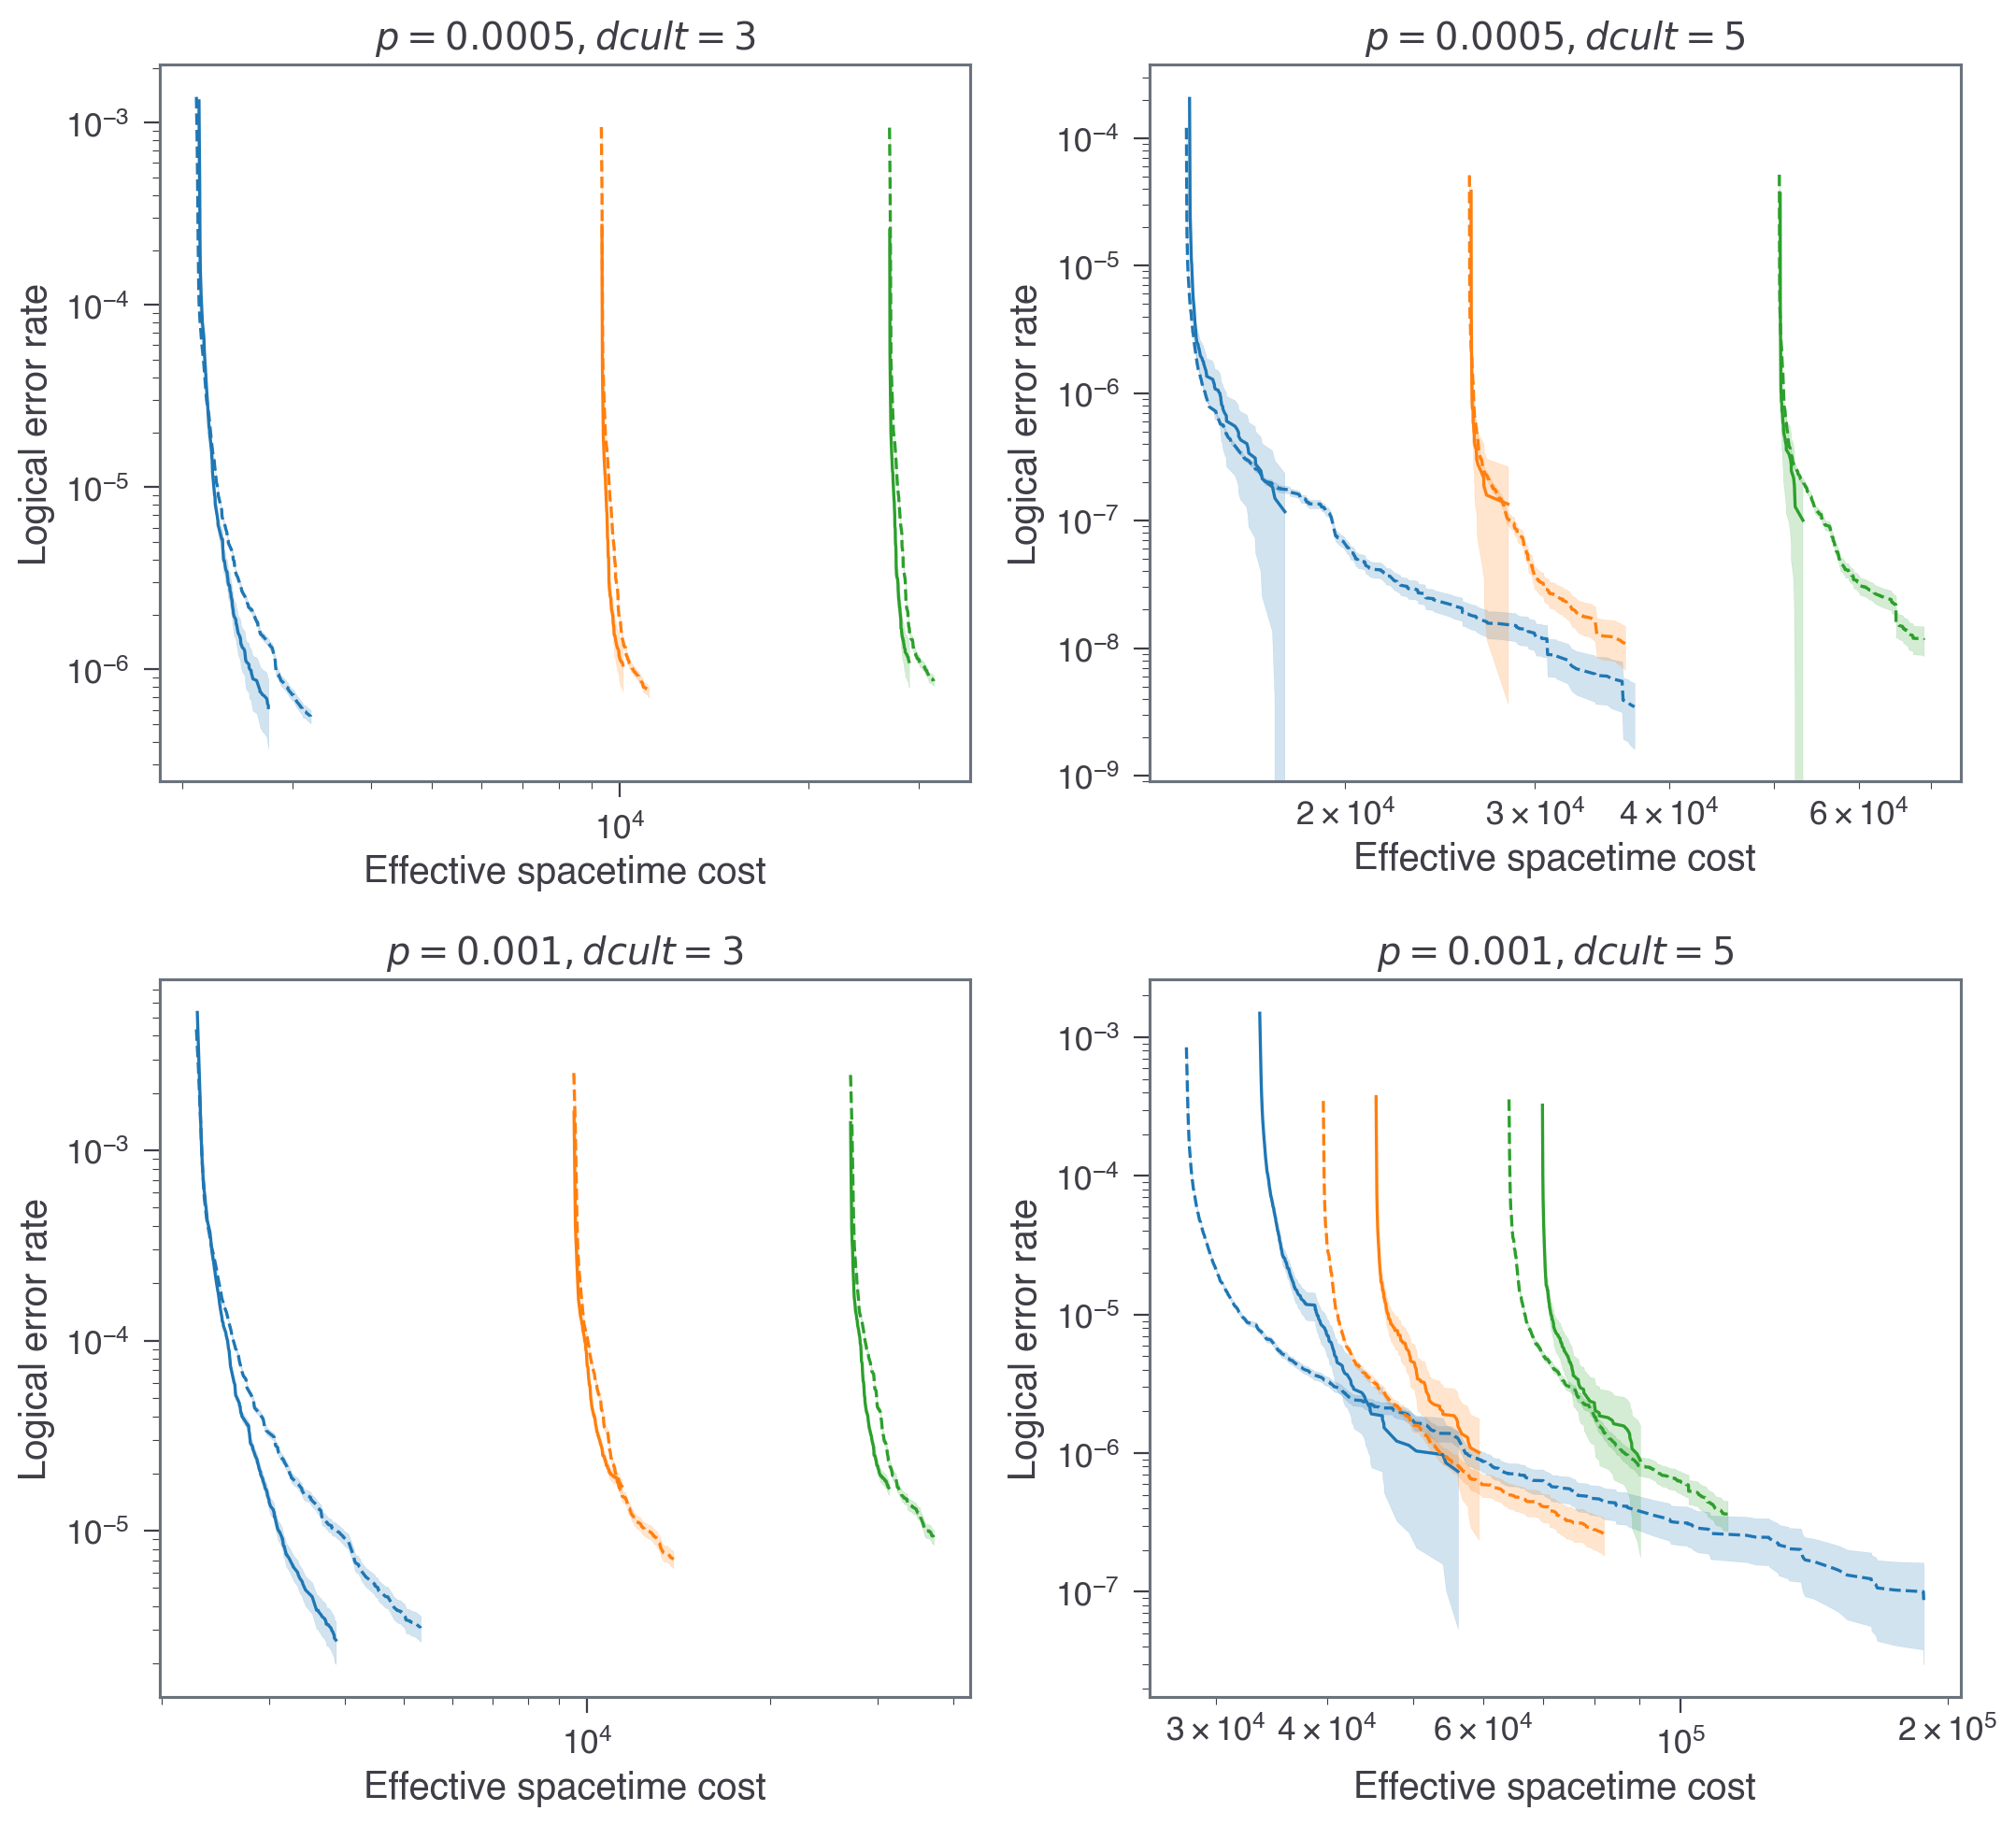

In [167]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(DFT_FIG_WIDTH_WIDE, 10))

for i_row in range(2):
    p = [5e-4, 1e-3][i_row]
    for i_col in range(2):
        dcult = [3, 5][i_col]
        ax = axes[i_row, i_col]

        dmlist = [dm for p_, dcult_, dm in dfs.keys() if p_ == p and dcult_ == dcult]
        for i_dm, dm in enumerate(dmlist):
            df = dfs[(p, dcult, dm)]
            df_org = dfs_org[(p, dcult, dm)]
            color = COLORS(i_dm)

            ax.plot(df["cost"], df["plog"], color=color, label=rf"together ($dm={dm}$)")
            ax.fill_between(df['cost'], df['plog'] - df['delta_plog'], df['plog'] + df['delta_plog'], color=color, alpha=0.2)
            ax.plot(
                df_org["cost"],
                df_org["plog"],
                color=color,
                linestyle="--",
                label=rf"separately ($dm={dm}$)",
            )
            ax.fill_between(
                df_org["cost"],
                df_org["plog"] - df_org["delta_plog"],
                df_org["plog"] + df_org["delta_plog"],
                color=color,
                alpha=0.2,
            )
        ax.set_xscale("log")
        ax.set_yscale("log")
        # ax.legend()
        ax.set_title(rf"$p={p}, dcult={dcult}$")
        ax.set_xlabel("Effective spacetime cost")
        ax.set_ylabel("Logical error rate")

fig.tight_layout()

In [163]:
dfs[5e-4, 5, 7].iloc[-1]

num_fails              0.000000e+00
num_accepted           2.827762e+07
plog                   1.173171e-07
delta_plog             1.173171e-07
psucc_growing          8.155295e-01
delta_psucc_growing    1.696675e-04
psucc_cult             3.467394e-01
delta_psucc_cult       1.225919e-04
cost                   1.757386e+04
Name: 18.87, dtype: float64

In [164]:
dfs_org[5e-4, 5, 7].iloc[-1]

plog_growing           3.441930e-09
delta_plog_growing     1.844003e-09
psucc_growing          3.835893e-01
delta_psucc_growing    1.549217e-05
plog                   3.461930e-09
delta_plog             1.844003e-09
psucc_cult             3.500000e-01
cost                   3.711410e+04
Name: 23.25, dtype: float64